# Notebook 02: Sessionize XuetangX

**Purpose:** Validate platform sessions OR re-sessionize with gap threshold.

**Cold-Start Focus:**
- Sessions define **temporal boundaries** for K-shot support → query splits
- Session quality affects **chronological ordering** (critical for cold-start evaluation)

**Inputs:**
- `data/interim/xuetangx.duckdb` (view: `xuetangx_events_raw`)

**Outputs:**
- `data/processed/xuetangx/sessions/events_sessionized.parquet`
- `data/processed/xuetangx/sessions/sessions.parquet`
- DuckDB views: `xuetangx_events_sessionized`, `xuetangx_sessions`
- `reports/02_sessionize_xuetangx/<run_tag>/report.json`

**Strategy (Hybrid):**
1. Parse timestamps (ISO 8601 → Unix epoch)
2. Validate platform `session_hash` (compute within-session gaps)
3. **Decision rule:** Use platform sessions if p90 gap < 30min, else re-sessionize
4. Save session tables + cold-start eligibility stats

In [1]:
# [CELL 02-00] Bootstrap: repo root + paths + logger

import os
import sys
import json
import time
import uuid
import hashlib
from pathlib import Path
from datetime import datetime, timezone
from typing import Any, Dict, List

import numpy as np
import pandas as pd

t0 = datetime.now()
print(f"[CELL 02-00] start={t0.isoformat(timespec='seconds')}")
print("[CELL 02-00] CWD:", Path.cwd().resolve())

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "PROJECT_STATE.md").exists():
            return p
    raise RuntimeError("Could not find PROJECT_STATE.md. Open notebook from within the repo.")

REPO_ROOT = find_repo_root(Path.cwd())
print("[CELL 02-00] REPO_ROOT:", REPO_ROOT)

PATHS = {
    "META_REGISTRY": REPO_ROOT / "meta.json",
    "DATA_INTERIM": REPO_ROOT / "data" / "interim",
    "DATA_PROCESSED": REPO_ROOT / "data" / "processed",
    "REPORTS": REPO_ROOT / "reports",
}
for k, v in PATHS.items():
    print(f"[CELL 02-00] {k}={v}")

def cell_start(cell_id: str, title: str, **kwargs: Any) -> float:
    t = time.time()
    print(f"\n[{cell_id}] {title}")
    print(f"[{cell_id}] start={datetime.now().isoformat(timespec='seconds')}")
    for k, v in kwargs.items():
        print(f"[{cell_id}] {k}={v}")
    return t

def cell_end(cell_id: str, t0: float, **kwargs: Any) -> None:
    for k, v in kwargs.items():
        print(f"[{cell_id}] {k}={v}")
    print(f"[{cell_id}] elapsed={time.time()-t0:.2f}s")
    print(f"[{cell_id}] done")

print("[CELL 02-00] done")

[CELL 02-00] start=2026-01-07T10:04:41
[CELL 02-00] CWD: C:\anonymous-users-mooc-session-meta\notebooks
[CELL 02-00] REPO_ROOT: C:\anonymous-users-mooc-session-meta
[CELL 02-00] META_REGISTRY=C:\anonymous-users-mooc-session-meta\meta.json
[CELL 02-00] DATA_INTERIM=C:\anonymous-users-mooc-session-meta\data\interim
[CELL 02-00] DATA_PROCESSED=C:\anonymous-users-mooc-session-meta\data\processed
[CELL 02-00] REPORTS=C:\anonymous-users-mooc-session-meta\reports
[CELL 02-00] done


In [2]:
# [CELL 02-01] Reproducibility: seed everything

t0 = cell_start("CELL 02-01", "Seed everything")

GLOBAL_SEED = 20260107

def seed_everything(seed: int) -> None:
    import random
    random.seed(seed)
    np.random.seed(seed)

seed_everything(GLOBAL_SEED)

cell_end("CELL 02-01", t0, seed=GLOBAL_SEED)


[CELL 02-01] Seed everything
[CELL 02-01] start=2026-01-07T10:04:41
[CELL 02-01] seed=20260107
[CELL 02-01] elapsed=0.00s
[CELL 02-01] done


In [3]:
# [CELL 02-02] JSON IO + hashing helpers

t0 = cell_start("CELL 02-02", "JSON IO + hashing")

def write_json_atomic(path: Path, obj: Any, indent: int = 2) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    tmp = path.with_suffix(path.suffix + f".tmp_{uuid.uuid4().hex}")
    with tmp.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=indent)
    tmp.replace(path)

def read_json(path: Path) -> Any:
    if not path.exists():
        raise RuntimeError(f"Missing JSON file: {path}")
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

def sha256_file(path: Path, chunk_size: int = 1024 * 1024) -> str:
    h = hashlib.sha256()
    with path.open("rb") as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

cell_end("CELL 02-02", t0)


[CELL 02-02] JSON IO + hashing
[CELL 02-02] start=2026-01-07T10:04:41
[CELL 02-02] elapsed=0.00s
[CELL 02-02] done


In [4]:
# [CELL 02-03] Run tagging + report/config/manifest + meta.json

t0 = cell_start("CELL 02-03", "Start run + init files + meta.json")

NOTEBOOK_NAME = "02_sessionize_xuetangx"
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_ID = uuid.uuid4().hex

OUT_DIR = PATHS["REPORTS"] / NOTEBOOK_NAME / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

REPORT_PATH = OUT_DIR / "report.json"
CONFIG_PATH = OUT_DIR / "config.json"
MANIFEST_PATH = OUT_DIR / "manifest.json"

DUCKDB_PATH = PATHS["DATA_INTERIM"] / "xuetangx.duckdb"
EVENTS_VIEW = "xuetangx_events_raw"

OUT_BASE = PATHS["DATA_PROCESSED"] / "xuetangx" / "sessions"
OUT_BASE.mkdir(parents=True, exist_ok=True)

OUT_EVENTS_PARQUET = OUT_BASE / "events_sessionized.parquet"
OUT_SESSIONS_PARQUET = OUT_BASE / "sessions.parquet"

CFG = {
    "notebook": NOTEBOOK_NAME,
    "run_id": RUN_ID,
    "run_tag": RUN_TAG,
    "seed": GLOBAL_SEED,
    "inputs": {
        "duckdb_path": str(DUCKDB_PATH),
        "events_view": EVENTS_VIEW,
    },
    "outputs": {
        "events_sessionized": str(OUT_EVENTS_PARQUET),
        "sessions": str(OUT_SESSIONS_PARQUET),
        "out_dir": str(OUT_DIR),
    },
    "sessionization": {
        "strategy": "hybrid_validate_platform",  # Validate platform session_hash first
        "gap_threshold_seconds": 1800,  # 30 minutes (fallback if platform fails)
        "platform_session_column": "session_hash",
        "decision_rule": "use_platform_if_p90_gap_lt_30min",
    },
    "cold_start_checks": {
        "min_interactions_K5_Q10": 15,
        "min_interactions_K10_Q20": 30,
    }
}

write_json_atomic(CONFIG_PATH, CFG)

report = {
    "run_id": RUN_ID,
    "notebook": NOTEBOOK_NAME,
    "run_tag": RUN_TAG,
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "repo_root": str(REPO_ROOT),
    "metrics": {},
    "key_findings": [],
    "sanity_samples": {},
    "data_fingerprints": {},
    "notes": [],
}
write_json_atomic(REPORT_PATH, report)

manifest = {"run_id": RUN_ID, "notebook": NOTEBOOK_NAME, "run_tag": RUN_TAG, "artifacts": []}
write_json_atomic(MANIFEST_PATH, manifest)

# meta.json append-only
META_PATH = PATHS["META_REGISTRY"]
if not META_PATH.exists():
    write_json_atomic(META_PATH, {"schema_version": 1, "runs": []})
meta = read_json(META_PATH)
meta["runs"].append({
    "run_id": RUN_ID,
    "notebook": NOTEBOOK_NAME,
    "run_tag": RUN_TAG,
    "out_dir": str(OUT_DIR),
    "created_at": datetime.now().isoformat(timespec="seconds"),
})
write_json_atomic(META_PATH, meta)

cell_end("CELL 02-03", t0, out_dir=str(OUT_DIR))


[CELL 02-03] Start run + init files + meta.json
[CELL 02-03] start=2026-01-07T10:04:41
[CELL 02-03] out_dir=C:\anonymous-users-mooc-session-meta\reports\02_sessionize_xuetangx\20260107_100441
[CELL 02-03] elapsed=0.03s
[CELL 02-03] done


In [5]:
# [CELL 02-04] Load events from DuckDB + parse timestamps

t0 = cell_start("CELL 02-04", "Load events + parse timestamps", duckdb=str(DUCKDB_PATH))

import duckdb

if not DUCKDB_PATH.exists():
    raise RuntimeError(f"Missing DuckDB: {DUCKDB_PATH}. Run Notebook 01 first.")

con = duckdb.connect(str(DUCKDB_PATH), read_only=True)

# Load all events
events = con.execute(f"SELECT * FROM {EVENTS_VIEW}").fetchdf()
con.close()

print(f"[CELL 02-04] Loaded events shape: {events.shape}")
print(f"[CELL 02-04] Columns: {list(events.columns)}")

# Parse timestamps (ISO 8601 → Unix epoch)
events["ts"] = pd.to_datetime(events["timestamp"], format="ISO8601", utc=True)
events["ts_epoch"] = events["ts"].astype(np.int64) // 10**9  # nanoseconds → seconds

# Sort by user, session, time (critical for gap computation)
events = events.sort_values(["user_id", "session_hash", "ts_epoch"]).reset_index(drop=True)

print(f"\n[CELL 02-04] Timestamp parsing:")
print(f"  Min ts: {events['ts'].min()}")
print(f"  Max ts: {events['ts'].max()}")
print(f"  Span: {(events['ts'].max() - events['ts'].min()).days} days")

print(f"\n[CELL 02-04] Head(3):")
print(events[["user_id", "course_id", "session_hash", "event_type", "ts", "ts_epoch"]].head(3).to_string(index=False))

cell_end("CELL 02-04", t0, n_events=int(events.shape[0]))


[CELL 02-04] Load events + parse timestamps
[CELL 02-04] start=2026-01-07T10:04:41
[CELL 02-04] duckdb=C:\anonymous-users-mooc-session-meta\data\interim\xuetangx.duckdb


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[CELL 02-04] Loaded events shape: (19239571, 6)
[CELL 02-04] Columns: ['course_id', 'user_id', 'session_hash', 'event_type', 'timestamp', '__source_file']

[CELL 02-04] Timestamp parsing:
  Min ts: 2015-07-31 23:59:14+00:00
  Max ts: 2015-10-31 23:59:16+00:00
  Span: 92 days

[CELL 02-04] Head(3):
user_id                             course_id                     session_hash  event_type                        ts   ts_epoch
      1                       UQx/Think101x/_ ed614e7cbc66a577d760911c5c1684d4  load_video 2015-09-03 00:55:06+00:00 1441241706
      1                       UQx/Think101x/_ ed614e7cbc66a577d760911c5c1684d4 problem_get 2015-09-03 00:55:13+00:00 1441241713
  10000 course-v1:TsinghuaX+40040152X+2015_T2 e20c166625ba46d905c81429dd713c97  load_video 2015-09-14 21:03:33+00:00 1442264613
[CELL 02-04] n_events=19239571
[CELL 02-04] elapsed=50.57s
[CELL 02-04] done


In [6]:
# [CELL 02-05] Validate platform sessions: compute within-session gaps

t0 = cell_start("CELL 02-05", "Validate platform sessions (gap analysis)")

# Compute time gap to next event within same (user, session)
events["next_ts_epoch"] = events.groupby(["user_id", "session_hash"])["ts_epoch"].shift(-1)
events["gap_seconds"] = events["next_ts_epoch"] - events["ts_epoch"]

# Filter to within-session gaps only (exclude last event per session)
within_sess_gaps = events[events["gap_seconds"].notna()]["gap_seconds"]

if len(within_sess_gaps) == 0:
    raise RuntimeError("No within-session gaps found. Check session_hash column.")

gap_stats = {
    "n_gaps": int(len(within_sess_gaps)),
    "min_sec": float(within_sess_gaps.min()),
    "p50_sec": float(within_sess_gaps.quantile(0.50)),
    "p90_sec": float(within_sess_gaps.quantile(0.90)),
    "p95_sec": float(within_sess_gaps.quantile(0.95)),
    "p99_sec": float(within_sess_gaps.quantile(0.99)),
    "max_sec": float(within_sess_gaps.max()),
    "mean_sec": float(within_sess_gaps.mean()),
}

print(f"[CELL 02-05] Within-session gap statistics:")
for k, v in gap_stats.items():
    if k == "n_gaps":
        print(f"  {k}: {v:,}")
    else:
        print(f"  {k}: {v:.1f}s ({v/60:.1f}min)")

# % of gaps exceeding thresholds
pct_gt_30min = float((within_sess_gaps > 1800).mean() * 100)
pct_gt_1hr = float((within_sess_gaps > 3600).mean() * 100)
pct_gt_1day = float((within_sess_gaps > 86400).mean() * 100)

print(f"\n[CELL 02-05] Gap threshold violations:")
print(f"  % gaps > 30min: {pct_gt_30min:.2f}%")
print(f"  % gaps > 1hr:   {pct_gt_1hr:.2f}%")
print(f"  % gaps > 1day:  {pct_gt_1day:.2f}%")

cell_end("CELL 02-05", t0, p90_gap_sec=gap_stats["p90_sec"])


[CELL 02-05] Validate platform sessions (gap analysis)
[CELL 02-05] start=2026-01-07T10:05:32
[CELL 02-05] Within-session gap statistics:
  n_gaps: 18,948,006
  min_sec: 0.0s (0.0min)
  p50_sec: 6.0s (0.1min)
  p90_sec: 220.0s (3.7min)
  p95_sec: 476.0s (7.9min)
  p99_sec: 22988.9s (383.1min)
  max_sec: 6125551.0s (102092.5min)
  mean_sec: 1665.7s (27.8min)

[CELL 02-05] Gap threshold violations:
  % gaps > 30min: 1.94%
  % gaps > 1hr:   1.56%
  % gaps > 1day:  0.48%
[CELL 02-05] p90_gap_sec=220.0
[CELL 02-05] elapsed=8.36s
[CELL 02-05] done


In [7]:
# [CELL 02-06] Decision: Use platform sessions OR re-sessionize

t0 = cell_start("CELL 02-06", "Sessionization decision")

GAP_THRESHOLD_SEC = int(CFG["sessionization"]["gap_threshold_seconds"])
p90_gap = gap_stats["p90_sec"]

# Decision rule: use platform if p90 gap < 30min
USE_PLATFORM_SESSIONS = (p90_gap < GAP_THRESHOLD_SEC)

print(f"[CELL 02-06] Decision rule: p90_gap ({p90_gap:.0f}s) < threshold ({GAP_THRESHOLD_SEC}s)?")
print(f"[CELL 02-06] USE_PLATFORM_SESSIONS: {USE_PLATFORM_SESSIONS}")

if USE_PLATFORM_SESSIONS:
    print(f"\n[CELL 02-06] ✅ Platform sessions are GOOD (p90={p90_gap/60:.1f}min < 30min)")
    print(f"[CELL 02-06] Using session_hash as-is (no re-sessionization needed)")
    events["session_id"] = events["user_id"].astype(str) + "_" + events["session_hash"].astype(str)
    sessionization_method = "platform_session_hash"
else:
    print(f"\n[CELL 02-06] ⚠️  Platform sessions are BAD (p90={p90_gap/60:.1f}min >= 30min)")
    print(f"[CELL 02-06] Re-sessionizing with {GAP_THRESHOLD_SEC}s gap threshold...")
    
    # Re-sessionize: new session starts when gap > threshold
    events["new_session"] = (events["gap_seconds"] > GAP_THRESHOLD_SEC) | (events["gap_seconds"].isna())
    events["sess_num"] = events.groupby("user_id")["new_session"].cumsum()
    events["session_id"] = events["user_id"].astype(str) + "_" + events["sess_num"].astype(str).str.zfill(6)
    sessionization_method = f"gap_{GAP_THRESHOLD_SEC}s"

print(f"\n[CELL 02-06] Sessionization method: {sessionization_method}")
print(f"[CELL 02-06] Unique session_ids: {events['session_id'].nunique():,}")

cell_end("CELL 02-06", t0, method=sessionization_method, n_sessions=int(events["session_id"].nunique()))


[CELL 02-06] Sessionization decision
[CELL 02-06] start=2026-01-07T10:05:40
[CELL 02-06] Decision rule: p90_gap (220s) < threshold (1800s)?
[CELL 02-06] USE_PLATFORM_SESSIONS: True

[CELL 02-06] ✅ Platform sessions are GOOD (p90=3.7min < 30min)
[CELL 02-06] Using session_hash as-is (no re-sessionization needed)

[CELL 02-06] Sessionization method: platform_session_hash
[CELL 02-06] Unique session_ids: 291,565
[CELL 02-06] method=platform_session_hash
[CELL 02-06] n_sessions=291565
[CELL 02-06] elapsed=7.63s
[CELL 02-06] done


In [8]:
# [CELL 02-07] Add session metadata (position, length)

t0 = cell_start("CELL 02-07", "Add session metadata")

# Position within session (1-indexed)
events["pos_in_sess"] = events.groupby("session_id").cumcount() + 1

# Session length
sess_lens = events.groupby("session_id").size().rename("sess_len")
events = events.merge(sess_lens.to_frame(), left_on="session_id", right_index=True, how="left")

print(f"[CELL 02-07] Added: pos_in_sess, sess_len")
print(f"\n[CELL 02-07] Session length distribution:")
print(f"  Min: {events['sess_len'].min()}")
print(f"  p50: {events['sess_len'].quantile(0.50):.0f}")
print(f"  p90: {events['sess_len'].quantile(0.90):.0f}")
print(f"  p95: {events['sess_len'].quantile(0.95):.0f}")
print(f"  p99: {events['sess_len'].quantile(0.99):.0f}")
print(f"  Max: {events['sess_len'].max()}")

print(f"\n[CELL 02-07] Head(3) with session metadata:")
print(events[["user_id", "session_id", "pos_in_sess", "sess_len", "event_type", "ts_epoch"]].head(3).to_string(index=False))

cell_end("CELL 02-07", t0)


[CELL 02-07] Add session metadata
[CELL 02-07] start=2026-01-07T10:05:48
[CELL 02-07] Added: pos_in_sess, sess_len

[CELL 02-07] Session length distribution:
  Min: 1
  p50: 231
  p90: 1802
  p95: 5440
  p99: 42094
  Max: 132442

[CELL 02-07] Head(3) with session metadata:
user_id                             session_id  pos_in_sess  sess_len  event_type   ts_epoch
      1     1_ed614e7cbc66a577d760911c5c1684d4            1         2  load_video 1441241706
      1     1_ed614e7cbc66a577d760911c5c1684d4            2         2 problem_get 1441241713
  10000 10000_e20c166625ba46d905c81429dd713c97            1        16  load_video 1442264613
[CELL 02-07] elapsed=22.82s
[CELL 02-07] done


In [9]:
# [CELL 02-08] Create session-level aggregates

t0 = cell_start("CELL 02-08", "Create session-level aggregates")

sessions = events.groupby("session_id").agg({
    "user_id": "first",
    "course_id": lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Most common course
    "ts_epoch": ["min", "max", "count"],
}).reset_index()

# Flatten MultiIndex columns
sessions.columns = ["session_id", "user_id", "course_id", "start_ts", "end_ts", "n_events"]
sessions["duration_sec"] = sessions["end_ts"] - sessions["start_ts"]

print(f"[CELL 02-08] Sessions shape: {sessions.shape}")
print(f"\n[CELL 02-08] Session duration distribution:")
print(f"  p50: {sessions['duration_sec'].quantile(0.50):.0f}s ({sessions['duration_sec'].quantile(0.50)/60:.1f}min)")
print(f"  p90: {sessions['duration_sec'].quantile(0.90):.0f}s ({sessions['duration_sec'].quantile(0.90)/60:.1f}min)")
print(f"  p99: {sessions['duration_sec'].quantile(0.99):.0f}s ({sessions['duration_sec'].quantile(0.99)/60:.1f}min)")

print(f"\n[CELL 02-08] Sessions head(3):")
print(sessions.head(3).to_string(index=False))

cell_end("CELL 02-08", t0, n_sessions=int(sessions.shape[0]))


[CELL 02-08] Create session-level aggregates
[CELL 02-08] start=2026-01-07T10:06:11
[CELL 02-08] Sessions shape: (291565, 7)

[CELL 02-08] Session duration distribution:
  p50: 2113s (35.2min)
  p90: 346368s (5772.8min)
  p99: 1527708s (25461.8min)

[CELL 02-08] Sessions head(3):
                              session_id user_id                   course_id   start_ts     end_ts  n_events  duration_sec
1000009_95163f59939941d9fd47d6c9b17fdaf6 1000009 TsinghuaX/20740042X/2015_T2 1443238719 1443245252        63          6533
1000009_bb35e205423d9a55713faa3231ee99a3 1000009 TsinghuaX/20740042X/2015_T2 1443920626 1444238801        45        318175
1000009_fc66167fab9ecbbb8d133380bd91b82b 1000009 TsinghuaX/30240243X/2015_T1 1440496639 1440499736        39          3097
[CELL 02-08] n_sessions=291565
[CELL 02-08] elapsed=60.79s
[CELL 02-08] done


In [10]:
# [CELL 02-09] Cold-start eligibility check (user-level)

t0 = cell_start("CELL 02-09", "Cold-start eligibility (user-level stats)")

user_stats = events.groupby("user_id").agg({
    "session_id": "nunique",  # sessions per user
    "event_type": "count",     # total events per user
}).rename(columns={"session_id": "n_sessions", "event_type": "n_events"}).reset_index()

print(f"[CELL 02-09] User stats shape: {user_stats.shape}")
print(f"\n[CELL 02-09] Events per user distribution:")
print(f"  Min: {user_stats['n_events'].min()}")
print(f"  p50: {user_stats['n_events'].quantile(0.50):.0f}")
print(f"  p90: {user_stats['n_events'].quantile(0.90):.0f}")
print(f"  p95: {user_stats['n_events'].quantile(0.95):.0f}")
print(f"  p99: {user_stats['n_events'].quantile(0.99):.0f}")
print(f"  Max: {user_stats['n_events'].max()}")

# Cold-start eligibility thresholds
min_15 = int(CFG["cold_start_checks"]["min_interactions_K5_Q10"])
min_30 = int(CFG["cold_start_checks"]["min_interactions_K10_Q20"])

elig_15 = user_stats[user_stats["n_events"] >= min_15]
elig_30 = user_stats[user_stats["n_events"] >= min_30]

print(f"\n[CELL 02-09] Cold-start eligibility (for K+Q budgets):")
print(f"  Users with ≥{min_15} events (K=5, Q=10):  {len(elig_15):,} / {len(user_stats):,} ({len(elig_15)/len(user_stats)*100:.1f}%)")
print(f"  Users with ≥{min_30} events (K=10, Q=20): {len(elig_30):,} / {len(user_stats):,} ({len(elig_30)/len(user_stats)*100:.1f}%)")

# After 80/10/10 split, expect ~10% in test
test_elig_15 = int(len(elig_15) * 0.10)
test_elig_30 = int(len(elig_30) * 0.10)

print(f"\n[CELL 02-09] Projected test set size (10% of eligible users):")
print(f"  K=5, Q=10:  ~{test_elig_15:,} test users")
print(f"  K=10, Q=20: ~{test_elig_30:,} test users")

if test_elig_15 < 50:
    print(f"\n[CELL 02-09] ⚠️  WARNING: <50 test users for K=5,Q=10 (need more data or lower K/Q)")
else:
    print(f"\n[CELL 02-09] ✅ Sufficient eligible users for statistically valid meta-learning experiments")

cell_end("CELL 02-09", t0, elig_K5Q10=len(elig_15), elig_K10Q20=len(elig_30))


[CELL 02-09] Cold-start eligibility (user-level stats)
[CELL 02-09] start=2026-01-07T10:07:12
[CELL 02-09] User stats shape: (107318, 3)

[CELL 02-09] Events per user distribution:
  Min: 1
  p50: 28
  p90: 460
  p95: 811
  p99: 1898
  Max: 137386

[CELL 02-09] Cold-start eligibility (for K+Q budgets):
  Users with ≥15 events (K=5, Q=10):  64,237 / 107,318 (59.9%)
  Users with ≥30 events (K=10, Q=20): 52,712 / 107,318 (49.1%)

[CELL 02-09] Projected test set size (10% of eligible users):
  K=5, Q=10:  ~6,423 test users
  K=10, Q=20: ~5,271 test users

[CELL 02-09] ✅ Sufficient eligible users for statistically valid meta-learning experiments
[CELL 02-09] elig_K5Q10=64237
[CELL 02-09] elig_K10Q20=52712
[CELL 02-09] elapsed=3.96s
[CELL 02-09] done


In [11]:
# [CELL 02-10] Save events_sessionized.parquet

t0 = cell_start("CELL 02-10", "Save events_sessionized.parquet", out=str(OUT_EVENTS_PARQUET))

# Select final columns (drop intermediate helpers)
events_out = events[[
    "user_id", "course_id", "session_id", "event_type", "timestamp", "ts_epoch",
    "pos_in_sess", "sess_len", "session_hash", "__source_file"
]].copy()

events_out.to_parquet(OUT_EVENTS_PARQUET, index=False, compression="zstd")

events_bytes = int(OUT_EVENTS_PARQUET.stat().st_size)
events_sha = sha256_file(OUT_EVENTS_PARQUET)

print(f"[CELL 02-10] Saved: {OUT_EVENTS_PARQUET}")
print(f"[CELL 02-10] Size: {events_bytes / 1024 / 1024:.1f} MB")
print(f"[CELL 02-10] SHA256: {events_sha}")

cell_end("CELL 02-10", t0)


[CELL 02-10] Save events_sessionized.parquet
[CELL 02-10] start=2026-01-07T10:07:16
[CELL 02-10] out=C:\anonymous-users-mooc-session-meta\data\processed\xuetangx\sessions\events_sessionized.parquet
[CELL 02-10] Saved: C:\anonymous-users-mooc-session-meta\data\processed\xuetangx\sessions\events_sessionized.parquet
[CELL 02-10] Size: 102.6 MB
[CELL 02-10] SHA256: e4e620d541af050d6e11f4b108c7868f18bd56a90e42d20b17ed02ed1284b69e
[CELL 02-10] elapsed=26.39s
[CELL 02-10] done


In [12]:
# [CELL 02-11] Save sessions.parquet

t0 = cell_start("CELL 02-11", "Save sessions.parquet", out=str(OUT_SESSIONS_PARQUET))

sessions.to_parquet(OUT_SESSIONS_PARQUET, index=False, compression="zstd")

sessions_bytes = int(OUT_SESSIONS_PARQUET.stat().st_size)
sessions_sha = sha256_file(OUT_SESSIONS_PARQUET)

print(f"[CELL 02-11] Saved: {OUT_SESSIONS_PARQUET}")
print(f"[CELL 02-11] Size: {sessions_bytes / 1024 / 1024:.1f} MB")
print(f"[CELL 02-11] SHA256: {sessions_sha}")

cell_end("CELL 02-11", t0)


[CELL 02-11] Save sessions.parquet
[CELL 02-11] start=2026-01-07T10:07:42
[CELL 02-11] out=C:\anonymous-users-mooc-session-meta\data\processed\xuetangx\sessions\sessions.parquet
[CELL 02-11] Saved: C:\anonymous-users-mooc-session-meta\data\processed\xuetangx\sessions\sessions.parquet
[CELL 02-11] Size: 10.1 MB
[CELL 02-11] SHA256: dcc64e612c5b0abc522eedcfb26d7475abb3505e69d54dec7ea9c2ed6963297e
[CELL 02-11] elapsed=0.44s
[CELL 02-11] done


In [13]:
# [CELL 02-12] Register DuckDB views

t0 = cell_start("CELL 02-12", "Register DuckDB views", duckdb=str(DUCKDB_PATH))

con = duckdb.connect(str(DUCKDB_PATH), read_only=False)

# Drop existing views if present
con.execute("DROP VIEW IF EXISTS xuetangx_events_sessionized;")
con.execute("DROP VIEW IF EXISTS xuetangx_sessions;")

# Create views pointing to parquet files
def esc_path(p: Path) -> str:
    return str(p).replace("'", "''")

con.execute(f"""
CREATE VIEW xuetangx_events_sessionized AS
SELECT * FROM read_parquet('{esc_path(OUT_EVENTS_PARQUET)}')
""")

con.execute(f"""
CREATE VIEW xuetangx_sessions AS
SELECT * FROM read_parquet('{esc_path(OUT_SESSIONS_PARQUET)}')
""")

# Verify
n_events = int(con.execute("SELECT COUNT(*) FROM xuetangx_events_sessionized").fetchone()[0])
n_sessions = int(con.execute("SELECT COUNT(*) FROM xuetangx_sessions").fetchone()[0])

print(f"[CELL 02-12] View xuetangx_events_sessionized: {n_events:,} rows")
print(f"[CELL 02-12] View xuetangx_sessions: {n_sessions:,} rows")

con.close()
print(f"[CELL 02-12] Closed DuckDB connection")

cell_end("CELL 02-12", t0)


[CELL 02-12] Register DuckDB views
[CELL 02-12] start=2026-01-07T10:07:42
[CELL 02-12] duckdb=C:\anonymous-users-mooc-session-meta\data\interim\xuetangx.duckdb
[CELL 02-12] View xuetangx_events_sessionized: 19,239,571 rows
[CELL 02-12] View xuetangx_sessions: 291,565 rows
[CELL 02-12] Closed DuckDB connection
[CELL 02-12] elapsed=0.56s
[CELL 02-12] done


In [14]:
# [CELL 02-13] Update report + manifest

t0 = cell_start("CELL 02-13", "Write report + manifest")

report = read_json(REPORT_PATH)
manifest = read_json(MANIFEST_PATH)

# Metrics
report["metrics"] = {
    "n_events": int(events_out.shape[0]),
    "n_sessions": int(sessions.shape[0]),
    "n_users": int(user_stats.shape[0]),
    "sessionization_method": sessionization_method,
    "gap_stats": gap_stats,
    "use_platform_sessions": USE_PLATFORM_SESSIONS,
    "cold_start_eligible_K5Q10": int(len(elig_15)),
    "cold_start_eligible_K10Q20": int(len(elig_30)),
    "projected_test_users_K5Q10": test_elig_15,
    "projected_test_users_K10Q20": test_elig_30,
}

# Key findings
if USE_PLATFORM_SESSIONS:
    report["key_findings"].append(
        f"Platform sessions validated (p90_gap={p90_gap/60:.1f}min < 30min). "
        f"Using session_hash as-is for cold-start user episodes."
    )
else:
    report["key_findings"].append(
        f"Platform sessions failed validation (p90_gap={p90_gap/60:.1f}min >= 30min). "
        f"Re-sessionized with {GAP_THRESHOLD_SEC}s gap threshold for cold-start evaluation."
    )

report["key_findings"].append(
    f"Cold-start eligibility: {len(elig_15):,} users with ≥15 events (K=5,Q=10), "
    f"{len(elig_30):,} users with ≥30 events (K=10,Q=20). "
    f"Projected ~{test_elig_15:,} test users for K=5,Q=10 after 80/10/10 split."
)

# Sanity samples
report["sanity_samples"]["events_sessionized_head3"] = events_out.head(3).to_dict(orient="records")
report["sanity_samples"]["sessions_head3"] = sessions.head(3).to_dict(orient="records")

# Fingerprints
report["data_fingerprints"]["events_sessionized"] = {
    "path": str(OUT_EVENTS_PARQUET),
    "bytes": events_bytes,
    "sha256": events_sha,
}
report["data_fingerprints"]["sessions"] = {
    "path": str(OUT_SESSIONS_PARQUET),
    "bytes": sessions_bytes,
    "sha256": sessions_sha,
}

write_json_atomic(REPORT_PATH, report)

# Manifest
def add_artifact(path: Path) -> None:
    rec = {"path": str(path), "bytes": int(path.stat().st_size), "sha256": None, "sha256_error": None}
    try:
        rec["sha256"] = sha256_file(path)
    except PermissionError as e:
        rec["sha256_error"] = f"PermissionError: {e}"
    manifest["artifacts"].append(rec)

add_artifact(OUT_EVENTS_PARQUET)
add_artifact(OUT_SESSIONS_PARQUET)
add_artifact(DUCKDB_PATH)

write_json_atomic(MANIFEST_PATH, manifest)

print(f"[CELL 02-13] Updated: {REPORT_PATH}")
print(f"[CELL 02-13] Updated: {MANIFEST_PATH}")

cell_end("CELL 02-13", t0)


[CELL 02-13] Write report + manifest
[CELL 02-13] start=2026-01-07T10:07:43
[CELL 02-13] Updated: C:\anonymous-users-mooc-session-meta\reports\02_sessionize_xuetangx\20260107_100441\report.json
[CELL 02-13] Updated: C:\anonymous-users-mooc-session-meta\reports\02_sessionize_xuetangx\20260107_100441\manifest.json
[CELL 02-13] elapsed=0.60s
[CELL 02-13] done



[CELL 02-14] Generate plots + tables for thesis/paper
[CELL 02-14] start=2026-01-07T10:09:23
[CELL 02-14] Saving plots to: C:\anonymous-users-mooc-session-meta\reports\02_sessionize_xuetangx\20260107_100441\plots
[CELL 02-14] Saved: fig1_gap_distribution.png


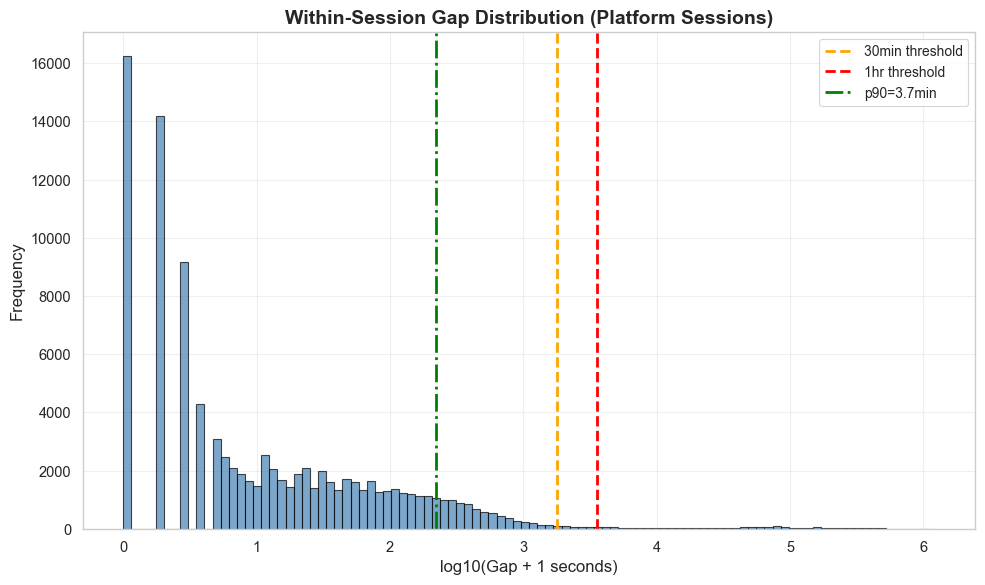

[CELL 02-14] Saved: fig2_user_engagement.png


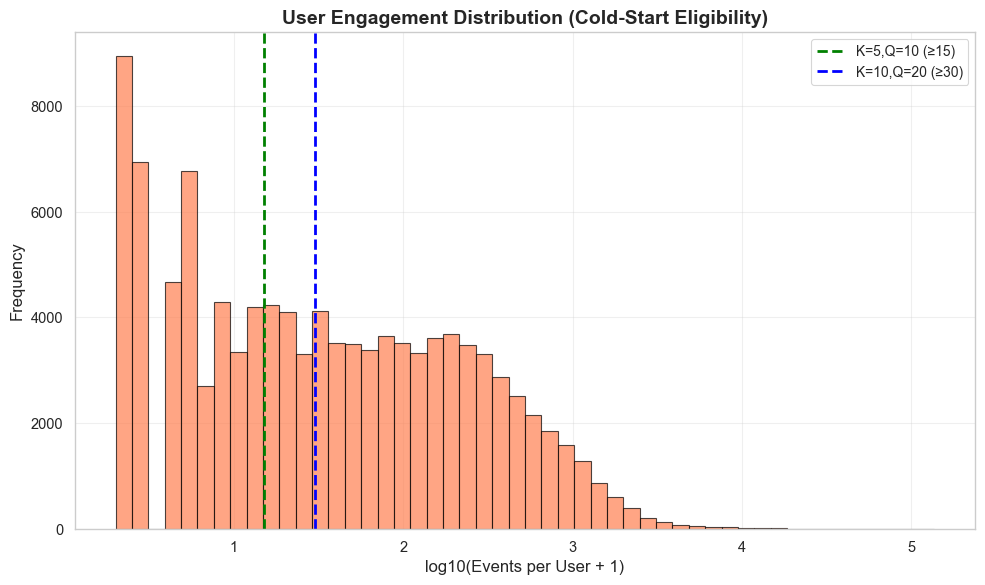

[CELL 02-14] Saved: fig3_session_length.png


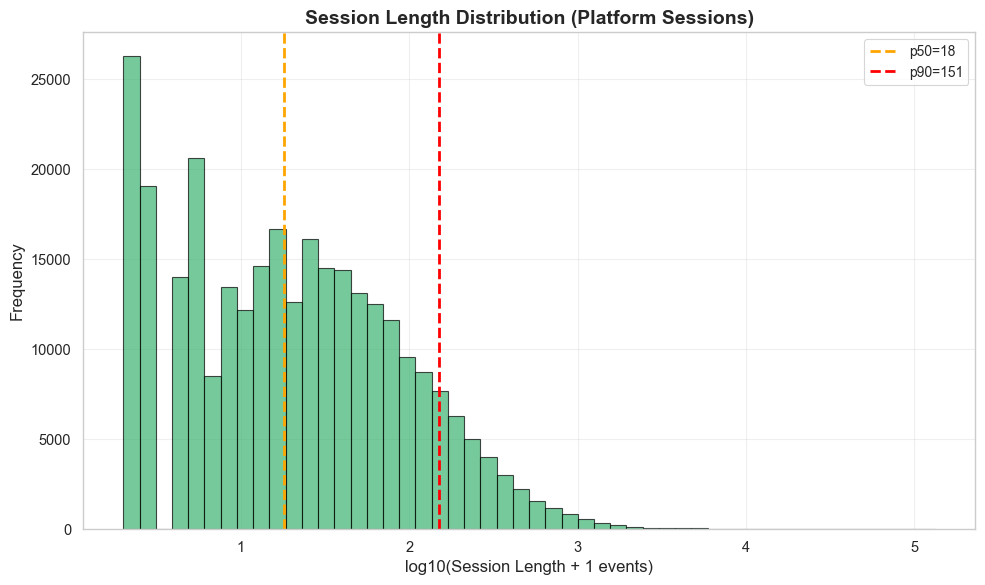

[CELL 02-14] Saved: fig4_eligibility_breakdown.png


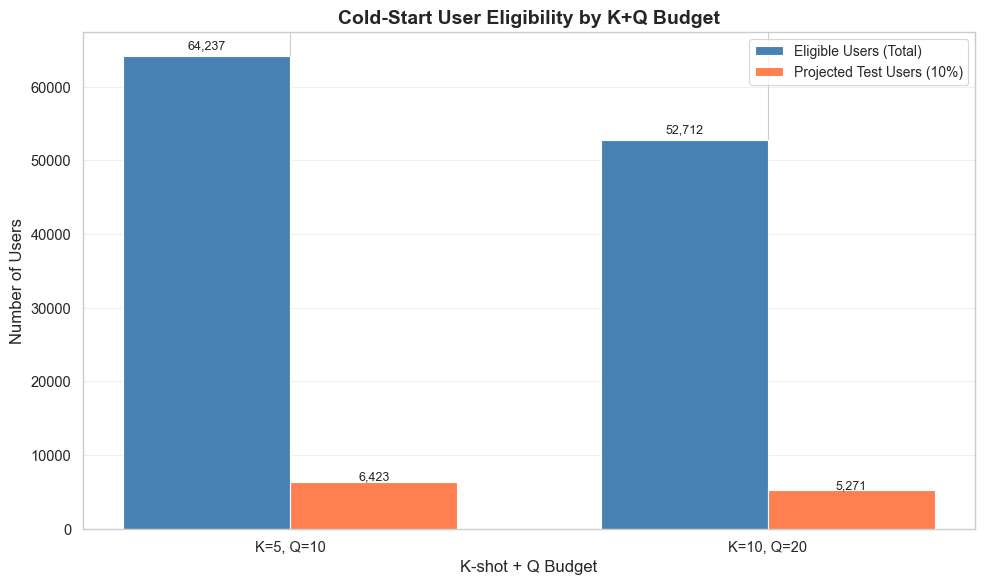


[CELL 02-14] ===== TABLE 1: Gap Statistics Summary =====
          Metric                 Value
      Total Gaps            18,948,006
         Min Gap                  0.0s
Median Gap (p50)         6.0s (0.1min)
         p90 Gap       220.0s (3.7min)
         p95 Gap       476.0s (7.9min)
         p99 Gap   22988.9s (383.1min)
         Max Gap 6125551.0s (1701.5hr)
  % Gaps > 30min                 1.94%
    % Gaps > 1hr                 1.56%
   % Gaps > 1day                 0.48%

[CELL 02-14] Saved: table1_gap_statistics.csv

[CELL 02-14] ===== TABLE 2: User Engagement Summary =====
                  Metric   Value
             Total Users 107,318
         Min Events/User       1
Median Events/User (p50)      28
         p90 Events/User     460
         p95 Events/User     811
         p99 Events/User    1898
         Max Events/User  137386
    Median Sessions/User       1
       p90 Sessions/User       6

[CELL 02-14] Saved: table2_user_engagement.csv

[CELL 02-14] ===== TABLE 3: 

In [16]:
# [CELL 02-14] Visualizations + Summary Tables for Reporting

t0 = cell_start("CELL 02-14", "Generate plots + tables for thesis/paper")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Create plots directory
PLOTS_DIR = OUT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"[CELL 02-14] Saving plots to: {PLOTS_DIR}")

# === Figure 1: Within-Session Gap Distribution (Log Scale) ===
fig, ax = plt.subplots(figsize=(10, 6))

# Sample 100K gaps for faster plotting
gaps_sample = within_sess_gaps.sample(min(100000, len(within_sess_gaps)), random_state=GLOBAL_SEED)

ax.hist(np.log10(gaps_sample + 1), bins=100, edgecolor="black", alpha=0.7, color="steelblue")
ax.set_xlabel("log10(Gap + 1 seconds)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Within-Session Gap Distribution (Platform Sessions)", fontsize=14, fontweight="bold")

# Add vertical lines for key thresholds
ax.axvline(np.log10(1800), color="orange", linestyle="--", linewidth=2, label="30min threshold")
ax.axvline(np.log10(3600), color="red", linestyle="--", linewidth=2, label="1hr threshold")
ax.axvline(np.log10(gap_stats["p90_sec"]), color="green", linestyle="-.", linewidth=2, label=f"p90={gap_stats['p90_sec']/60:.1f}min")

ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()

fig1_path = PLOTS_DIR / "fig1_gap_distribution.png"
plt.savefig(fig1_path, dpi=300, bbox_inches="tight")
print(f"[CELL 02-14] Saved: {fig1_path.name}")
plt.show()

# === Figure 2: User Engagement Distribution (Events per User) ===
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(np.log10(user_stats["n_events"] + 1), bins=50, edgecolor="black", alpha=0.7, color="coral")
ax.set_xlabel("log10(Events per User + 1)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("User Engagement Distribution (Cold-Start Eligibility)", fontsize=14, fontweight="bold")

# Add vertical lines for K+Q thresholds
ax.axvline(np.log10(min_15), color="green", linestyle="--", linewidth=2, label=f"K=5,Q=10 (≥{min_15})")
ax.axvline(np.log10(min_30), color="blue", linestyle="--", linewidth=2, label=f"K=10,Q=20 (≥{min_30})")

ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()

fig2_path = PLOTS_DIR / "fig2_user_engagement.png"
plt.savefig(fig2_path, dpi=300, bbox_inches="tight")
print(f"[CELL 02-14] Saved: {fig2_path.name}")
plt.show()

# === Figure 3: Session Length Distribution ===
fig, ax = plt.subplots(figsize=(10, 6))

sess_len_dist = events.groupby("session_id")["pos_in_sess"].max()
ax.hist(np.log10(sess_len_dist + 1), bins=50, edgecolor="black", alpha=0.7, color="mediumseagreen")
ax.set_xlabel("log10(Session Length + 1 events)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Session Length Distribution (Platform Sessions)", fontsize=14, fontweight="bold")

# Add median/p90 lines
ax.axvline(np.log10(sess_len_dist.quantile(0.50)), color="orange", linestyle="--", linewidth=2, label=f"p50={sess_len_dist.quantile(0.50):.0f}")
ax.axvline(np.log10(sess_len_dist.quantile(0.90)), color="red", linestyle="--", linewidth=2, label=f"p90={sess_len_dist.quantile(0.90):.0f}")

ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()

fig3_path = PLOTS_DIR / "fig3_session_length.png"
plt.savefig(fig3_path, dpi=300, bbox_inches="tight")
print(f"[CELL 02-14] Saved: {fig3_path.name}")
plt.show()

# === Figure 4: Cold-Start Eligibility Breakdown (Bar Chart) ===
fig, ax = plt.subplots(figsize=(10, 6))

elig_data = pd.DataFrame([
    {"Budget": "K=5, Q=10", "Eligible Users": len(elig_15), "Test Users (10%)": test_elig_15},
    {"Budget": "K=10, Q=20", "Eligible Users": len(elig_30), "Test Users (10%)": test_elig_30},
])

x = np.arange(len(elig_data))
width = 0.35

ax.bar(x - width/2, elig_data["Eligible Users"], width, label="Eligible Users (Total)", color="steelblue")
ax.bar(x + width/2, elig_data["Test Users (10%)"], width, label="Projected Test Users (10%)", color="coral")

ax.set_xlabel("K-shot + Q Budget", fontsize=12)
ax.set_ylabel("Number of Users", fontsize=12)
ax.set_title("Cold-Start User Eligibility by K+Q Budget", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(elig_data["Budget"])
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for i, row in elig_data.iterrows():
    ax.text(i - width/2, row["Eligible Users"] + 1000, f"{row['Eligible Users']:,}", ha="center", fontsize=9)
    ax.text(i + width/2, row["Test Users (10%)"] + 200, f"{row['Test Users (10%)']:,}", ha="center", fontsize=9)

plt.tight_layout()

fig4_path = PLOTS_DIR / "fig4_eligibility_breakdown.png"
plt.savefig(fig4_path, dpi=300, bbox_inches="tight")
print(f"[CELL 02-14] Saved: {fig4_path.name}")
plt.show()

# === Table 1: Gap Statistics Summary ===
print(f"\n[CELL 02-14] ===== TABLE 1: Gap Statistics Summary =====")
gap_table = pd.DataFrame([
    {"Metric": "Total Gaps", "Value": f"{gap_stats['n_gaps']:,}"},
    {"Metric": "Min Gap", "Value": f"{gap_stats['min_sec']:.1f}s"},
    {"Metric": "Median Gap (p50)", "Value": f"{gap_stats['p50_sec']:.1f}s ({gap_stats['p50_sec']/60:.1f}min)"},
    {"Metric": "p90 Gap", "Value": f"{gap_stats['p90_sec']:.1f}s ({gap_stats['p90_sec']/60:.1f}min)"},
    {"Metric": "p95 Gap", "Value": f"{gap_stats['p95_sec']:.1f}s ({gap_stats['p95_sec']/60:.1f}min)"},
    {"Metric": "p99 Gap", "Value": f"{gap_stats['p99_sec']:.1f}s ({gap_stats['p99_sec']/60:.1f}min)"},
    {"Metric": "Max Gap", "Value": f"{gap_stats['max_sec']:.1f}s ({gap_stats['max_sec']/3600:.1f}hr)"},
    {"Metric": "% Gaps > 30min", "Value": f"{pct_gt_30min:.2f}%"},
    {"Metric": "% Gaps > 1hr", "Value": f"{pct_gt_1hr:.2f}%"},
    {"Metric": "% Gaps > 1day", "Value": f"{pct_gt_1day:.2f}%"},
])
print(gap_table.to_string(index=False))

# Save as CSV
gap_table_path = OUT_DIR / "table1_gap_statistics.csv"
gap_table.to_csv(gap_table_path, index=False)
print(f"\n[CELL 02-14] Saved: {gap_table_path.name}")

# === Table 2: User Engagement Summary ===
print(f"\n[CELL 02-14] ===== TABLE 2: User Engagement Summary =====")
user_table = pd.DataFrame([
    {"Metric": "Total Users", "Value": f"{len(user_stats):,}"},
    {"Metric": "Min Events/User", "Value": f"{user_stats['n_events'].min()}"},
    {"Metric": "Median Events/User (p50)", "Value": f"{user_stats['n_events'].quantile(0.50):.0f}"},
    {"Metric": "p90 Events/User", "Value": f"{user_stats['n_events'].quantile(0.90):.0f}"},
    {"Metric": "p95 Events/User", "Value": f"{user_stats['n_events'].quantile(0.95):.0f}"},
    {"Metric": "p99 Events/User", "Value": f"{user_stats['n_events'].quantile(0.99):.0f}"},
    {"Metric": "Max Events/User", "Value": f"{user_stats['n_events'].max()}"},
    {"Metric": "Median Sessions/User", "Value": f"{user_stats['n_sessions'].quantile(0.50):.0f}"},
    {"Metric": "p90 Sessions/User", "Value": f"{user_stats['n_sessions'].quantile(0.90):.0f}"},
])
print(user_table.to_string(index=False))

# Save as CSV
user_table_path = OUT_DIR / "table2_user_engagement.csv"
user_table.to_csv(user_table_path, index=False)
print(f"\n[CELL 02-14] Saved: {user_table_path.name}")

# === Table 3: Cold-Start Eligibility Summary ===
print(f"\n[CELL 02-14] ===== TABLE 3: Cold-Start Eligibility Summary =====")
elig_table = pd.DataFrame([
    {"K": 5, "Q": 10, "Min Events Required": min_15, "Eligible Users": f"{len(elig_15):,}",
     "% of Total": f"{len(elig_15)/len(user_stats)*100:.1f}%", "Projected Test Users (10%)": f"{test_elig_15:,}"},
    {"K": 10, "Q": 20, "Min Events Required": min_30, "Eligible Users": f"{len(elig_30):,}",
     "% of Total": f"{len(elig_30)/len(user_stats)*100:.1f}%", "Projected Test Users (10%)": f"{test_elig_30:,}"},
])
print(elig_table.to_string(index=False))

# Save as CSV
elig_table_path = OUT_DIR / "table3_cold_start_eligibility.csv"
elig_table.to_csv(elig_table_path, index=False)
print(f"\n[CELL 02-14] Saved: {elig_table_path.name}")

# === Table 4: Session Statistics Summary ===
print(f"\n[CELL 02-14] ===== TABLE 4: Session Statistics Summary =====")
sess_table = pd.DataFrame([
    {"Metric": "Total Sessions", "Value": f"{len(sessions):,}"},
    {"Metric": "Min Session Length", "Value": f"{sess_len_dist.min()} events"},
    {"Metric": "Median Session Length (p50)", "Value": f"{sess_len_dist.quantile(0.50):.0f} events"},
    {"Metric": "p90 Session Length", "Value": f"{sess_len_dist.quantile(0.90):.0f} events"},
    {"Metric": "p99 Session Length", "Value": f"{sess_len_dist.quantile(0.99):.0f} events"},
    {"Metric": "Max Session Length", "Value": f"{sess_len_dist.max()} events"},
    {"Metric": "Median Duration (p50)", "Value": f"{sessions['duration_sec'].quantile(0.50):.0f}s ({sessions['duration_sec'].quantile(0.50)/60:.1f}min)"},
    {"Metric": "p90 Duration", "Value": f"{sessions['duration_sec'].quantile(0.90):.0f}s ({sessions['duration_sec'].quantile(0.90)/60:.1f}min)"},
    {"Metric": "p99 Duration", "Value": f"{sessions['duration_sec'].quantile(0.99):.0f}s ({sessions['duration_sec'].quantile(0.99)/60:.1f}min)"},
])
print(sess_table.to_string(index=False))

# Save as CSV
sess_table_path = OUT_DIR / "table4_session_statistics.csv"
sess_table.to_csv(sess_table_path, index=False)
print(f"\n[CELL 02-14] Saved: {sess_table_path.name}")

# Update manifest with plots + tables
manifest = read_json(MANIFEST_PATH)
for p in [fig1_path, fig2_path, fig3_path, fig4_path, gap_table_path, user_table_path, elig_table_path, sess_table_path]:
    if p.exists():
        manifest["artifacts"].append({"path": str(p), "bytes": int(p.stat().st_size), "type": "visualization"})
write_json_atomic(MANIFEST_PATH, manifest)

print(f"\n[CELL 02-14] ===== All visualizations + tables complete =====")
print(f"[CELL 02-14] Plots saved to: {PLOTS_DIR}")
print(f"[CELL 02-14] Tables saved to: {OUT_DIR}")

cell_end("CELL 02-14", t0)



[CELL 02-14] Generate plots + tables for thesis/paper
[CELL 02-14] start=2026-01-07T10:10:07
[CELL 02-14] Saving plots to: C:\anonymous-users-mooc-session-meta\reports\02_sessionize_xuetangx\20260107_100441\plots
[CELL 02-14] Saved: fig1_gap_distribution.png


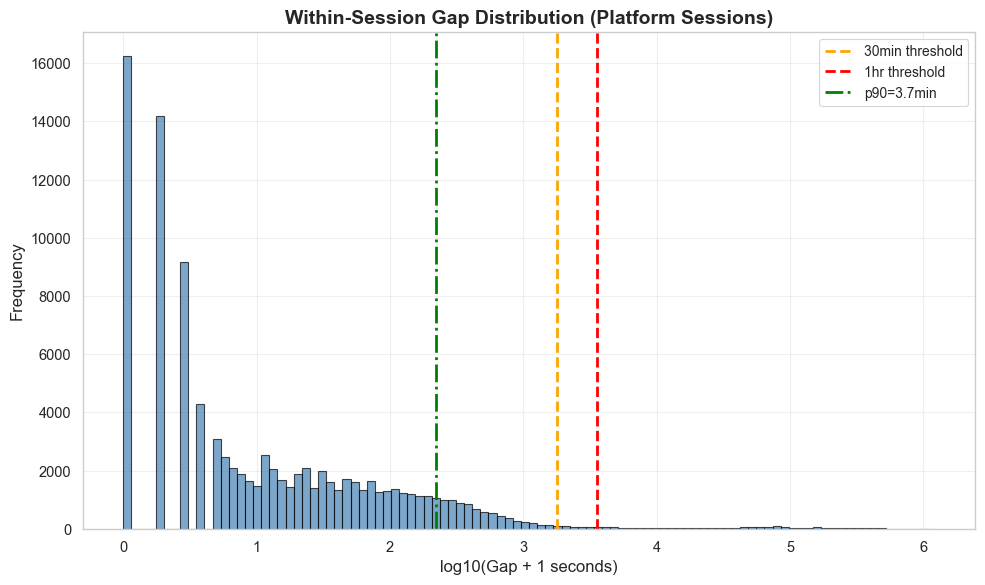

[CELL 02-14] Saved: fig2_user_engagement.png


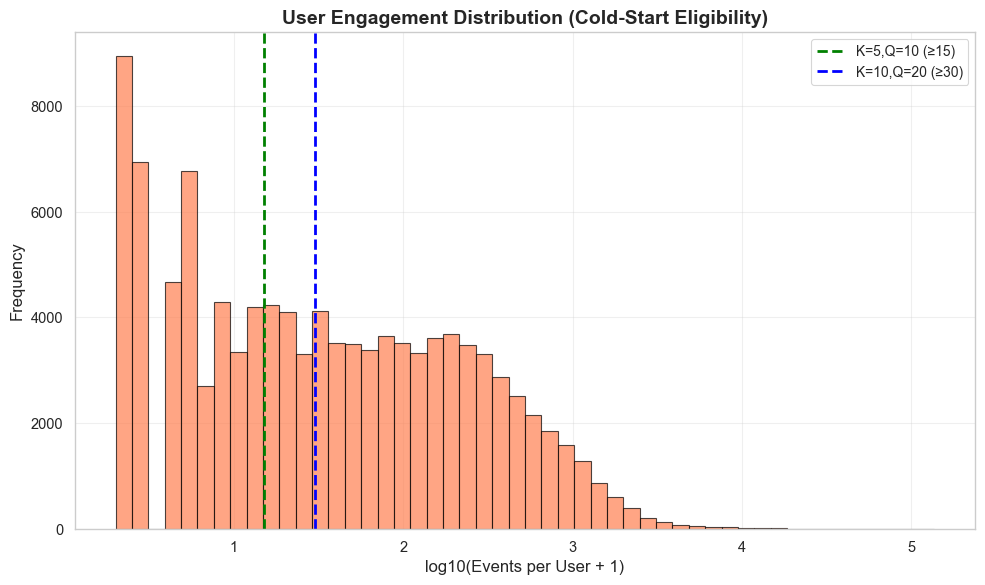

[CELL 02-14] Saved: fig3_session_length.png


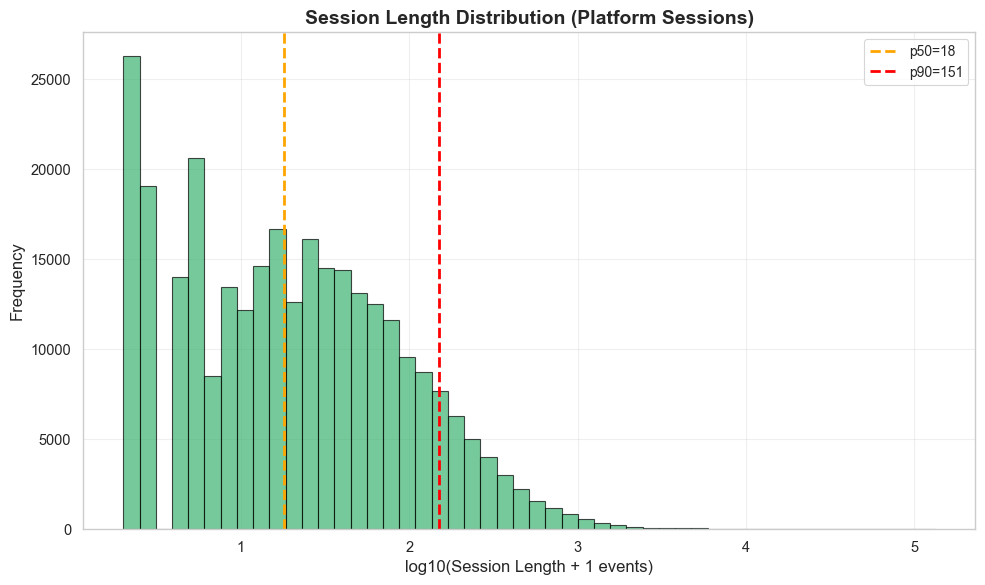

[CELL 02-14] Saved: fig4_eligibility_breakdown.png


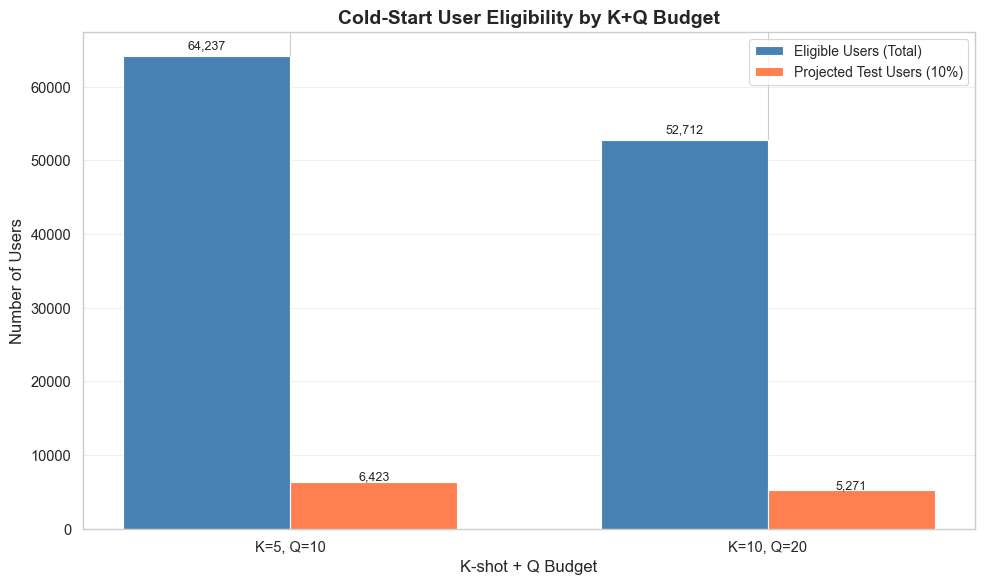


[CELL 02-14] ===== TABLE 1: Gap Statistics Summary =====
          Metric                 Value
      Total Gaps            18,948,006
         Min Gap                  0.0s
Median Gap (p50)         6.0s (0.1min)
         p90 Gap       220.0s (3.7min)
         p95 Gap       476.0s (7.9min)
         p99 Gap   22988.9s (383.1min)
         Max Gap 6125551.0s (1701.5hr)
  % Gaps > 30min                 1.94%
    % Gaps > 1hr                 1.56%
   % Gaps > 1day                 0.48%

[CELL 02-14] Saved: table1_gap_statistics.csv

[CELL 02-14] ===== TABLE 2: User Engagement Summary =====
                  Metric   Value
             Total Users 107,318
         Min Events/User       1
Median Events/User (p50)      28
         p90 Events/User     460
         p95 Events/User     811
         p99 Events/User    1898
         Max Events/User  137386
    Median Sessions/User       1
       p90 Sessions/User       6

[CELL 02-14] Saved: table2_user_engagement.csv

[CELL 02-14] ===== TABLE 3: 

In [17]:
# [CELL 02-14] Visualizations + Summary Tables for Reporting

t0 = cell_start("CELL 02-14", "Generate plots + tables for thesis/paper")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Create plots directory
PLOTS_DIR = OUT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"[CELL 02-14] Saving plots to: {PLOTS_DIR}")

# === Figure 1: Within-Session Gap Distribution (Log Scale) ===
fig, ax = plt.subplots(figsize=(10, 6))

# Sample 100K gaps for faster plotting
gaps_sample = within_sess_gaps.sample(min(100000, len(within_sess_gaps)), random_state=GLOBAL_SEED)

ax.hist(np.log10(gaps_sample + 1), bins=100, edgecolor="black", alpha=0.7, color="steelblue")
ax.set_xlabel("log10(Gap + 1 seconds)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Within-Session Gap Distribution (Platform Sessions)", fontsize=14, fontweight="bold")

# Add vertical lines for key thresholds
ax.axvline(np.log10(1800), color="orange", linestyle="--", linewidth=2, label="30min threshold")
ax.axvline(np.log10(3600), color="red", linestyle="--", linewidth=2, label="1hr threshold")
ax.axvline(np.log10(gap_stats["p90_sec"]), color="green", linestyle="-.", linewidth=2, label=f"p90={gap_stats['p90_sec']/60:.1f}min")

ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()

fig1_path = PLOTS_DIR / "fig1_gap_distribution.png"
plt.savefig(fig1_path, dpi=300, bbox_inches="tight")
print(f"[CELL 02-14] Saved: {fig1_path.name}")
plt.show()

# === Figure 2: User Engagement Distribution (Events per User) ===
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(np.log10(user_stats["n_events"] + 1), bins=50, edgecolor="black", alpha=0.7, color="coral")
ax.set_xlabel("log10(Events per User + 1)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("User Engagement Distribution (Cold-Start Eligibility)", fontsize=14, fontweight="bold")

# Add vertical lines for K+Q thresholds
ax.axvline(np.log10(min_15), color="green", linestyle="--", linewidth=2, label=f"K=5,Q=10 (≥{min_15})")
ax.axvline(np.log10(min_30), color="blue", linestyle="--", linewidth=2, label=f"K=10,Q=20 (≥{min_30})")

ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()

fig2_path = PLOTS_DIR / "fig2_user_engagement.png"
plt.savefig(fig2_path, dpi=300, bbox_inches="tight")
print(f"[CELL 02-14] Saved: {fig2_path.name}")
plt.show()

# === Figure 3: Session Length Distribution ===
fig, ax = plt.subplots(figsize=(10, 6))

sess_len_dist = events.groupby("session_id")["pos_in_sess"].max()
ax.hist(np.log10(sess_len_dist + 1), bins=50, edgecolor="black", alpha=0.7, color="mediumseagreen")
ax.set_xlabel("log10(Session Length + 1 events)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Session Length Distribution (Platform Sessions)", fontsize=14, fontweight="bold")

# Add median/p90 lines
ax.axvline(np.log10(sess_len_dist.quantile(0.50)), color="orange", linestyle="--", linewidth=2, label=f"p50={sess_len_dist.quantile(0.50):.0f}")
ax.axvline(np.log10(sess_len_dist.quantile(0.90)), color="red", linestyle="--", linewidth=2, label=f"p90={sess_len_dist.quantile(0.90):.0f}")

ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()

fig3_path = PLOTS_DIR / "fig3_session_length.png"
plt.savefig(fig3_path, dpi=300, bbox_inches="tight")
print(f"[CELL 02-14] Saved: {fig3_path.name}")
plt.show()

# === Figure 4: Cold-Start Eligibility Breakdown (Bar Chart) ===
fig, ax = plt.subplots(figsize=(10, 6))

elig_data = pd.DataFrame([
    {"Budget": "K=5, Q=10", "Eligible Users": len(elig_15), "Test Users (10%)": test_elig_15},
    {"Budget": "K=10, Q=20", "Eligible Users": len(elig_30), "Test Users (10%)": test_elig_30},
])

x = np.arange(len(elig_data))
width = 0.35

ax.bar(x - width/2, elig_data["Eligible Users"], width, label="Eligible Users (Total)", color="steelblue")
ax.bar(x + width/2, elig_data["Test Users (10%)"], width, label="Projected Test Users (10%)", color="coral")

ax.set_xlabel("K-shot + Q Budget", fontsize=12)
ax.set_ylabel("Number of Users", fontsize=12)
ax.set_title("Cold-Start User Eligibility by K+Q Budget", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(elig_data["Budget"])
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for i, row in elig_data.iterrows():
    ax.text(i - width/2, row["Eligible Users"] + 1000, f"{row['Eligible Users']:,}", ha="center", fontsize=9)
    ax.text(i + width/2, row["Test Users (10%)"] + 200, f"{row['Test Users (10%)']:,}", ha="center", fontsize=9)

plt.tight_layout()

fig4_path = PLOTS_DIR / "fig4_eligibility_breakdown.png"
plt.savefig(fig4_path, dpi=300, bbox_inches="tight")
print(f"[CELL 02-14] Saved: {fig4_path.name}")
plt.show()

# === Table 1: Gap Statistics Summary ===
print(f"\n[CELL 02-14] ===== TABLE 1: Gap Statistics Summary =====")
gap_table = pd.DataFrame([
    {"Metric": "Total Gaps", "Value": f"{gap_stats['n_gaps']:,}"},
    {"Metric": "Min Gap", "Value": f"{gap_stats['min_sec']:.1f}s"},
    {"Metric": "Median Gap (p50)", "Value": f"{gap_stats['p50_sec']:.1f}s ({gap_stats['p50_sec']/60:.1f}min)"},
    {"Metric": "p90 Gap", "Value": f"{gap_stats['p90_sec']:.1f}s ({gap_stats['p90_sec']/60:.1f}min)"},
    {"Metric": "p95 Gap", "Value": f"{gap_stats['p95_sec']:.1f}s ({gap_stats['p95_sec']/60:.1f}min)"},
    {"Metric": "p99 Gap", "Value": f"{gap_stats['p99_sec']:.1f}s ({gap_stats['p99_sec']/60:.1f}min)"},
    {"Metric": "Max Gap", "Value": f"{gap_stats['max_sec']:.1f}s ({gap_stats['max_sec']/3600:.1f}hr)"},
    {"Metric": "% Gaps > 30min", "Value": f"{pct_gt_30min:.2f}%"},
    {"Metric": "% Gaps > 1hr", "Value": f"{pct_gt_1hr:.2f}%"},
    {"Metric": "% Gaps > 1day", "Value": f"{pct_gt_1day:.2f}%"},
])
print(gap_table.to_string(index=False))

# Save as CSV
gap_table_path = OUT_DIR / "table1_gap_statistics.csv"
gap_table.to_csv(gap_table_path, index=False)
print(f"\n[CELL 02-14] Saved: {gap_table_path.name}")

# === Table 2: User Engagement Summary ===
print(f"\n[CELL 02-14] ===== TABLE 2: User Engagement Summary =====")
user_table = pd.DataFrame([
    {"Metric": "Total Users", "Value": f"{len(user_stats):,}"},
    {"Metric": "Min Events/User", "Value": f"{user_stats['n_events'].min()}"},
    {"Metric": "Median Events/User (p50)", "Value": f"{user_stats['n_events'].quantile(0.50):.0f}"},
    {"Metric": "p90 Events/User", "Value": f"{user_stats['n_events'].quantile(0.90):.0f}"},
    {"Metric": "p95 Events/User", "Value": f"{user_stats['n_events'].quantile(0.95):.0f}"},
    {"Metric": "p99 Events/User", "Value": f"{user_stats['n_events'].quantile(0.99):.0f}"},
    {"Metric": "Max Events/User", "Value": f"{user_stats['n_events'].max()}"},
    {"Metric": "Median Sessions/User", "Value": f"{user_stats['n_sessions'].quantile(0.50):.0f}"},
    {"Metric": "p90 Sessions/User", "Value": f"{user_stats['n_sessions'].quantile(0.90):.0f}"},
])
print(user_table.to_string(index=False))

# Save as CSV
user_table_path = OUT_DIR / "table2_user_engagement.csv"
user_table.to_csv(user_table_path, index=False)
print(f"\n[CELL 02-14] Saved: {user_table_path.name}")

# === Table 3: Cold-Start Eligibility Summary ===
print(f"\n[CELL 02-14] ===== TABLE 3: Cold-Start Eligibility Summary =====")
elig_table = pd.DataFrame([
    {"K": 5, "Q": 10, "Min Events Required": min_15, "Eligible Users": f"{len(elig_15):,}",
     "% of Total": f"{len(elig_15)/len(user_stats)*100:.1f}%", "Projected Test Users (10%)": f"{test_elig_15:,}"},
    {"K": 10, "Q": 20, "Min Events Required": min_30, "Eligible Users": f"{len(elig_30):,}",
     "% of Total": f"{len(elig_30)/len(user_stats)*100:.1f}%", "Projected Test Users (10%)": f"{test_elig_30:,}"},
])
print(elig_table.to_string(index=False))

# Save as CSV
elig_table_path = OUT_DIR / "table3_cold_start_eligibility.csv"
elig_table.to_csv(elig_table_path, index=False)
print(f"\n[CELL 02-14] Saved: {elig_table_path.name}")

# === Table 4: Session Statistics Summary ===
print(f"\n[CELL 02-14] ===== TABLE 4: Session Statistics Summary =====")
sess_table = pd.DataFrame([
    {"Metric": "Total Sessions", "Value": f"{len(sessions):,}"},
    {"Metric": "Min Session Length", "Value": f"{sess_len_dist.min()} events"},
    {"Metric": "Median Session Length (p50)", "Value": f"{sess_len_dist.quantile(0.50):.0f} events"},
    {"Metric": "p90 Session Length", "Value": f"{sess_len_dist.quantile(0.90):.0f} events"},
    {"Metric": "p99 Session Length", "Value": f"{sess_len_dist.quantile(0.99):.0f} events"},
    {"Metric": "Max Session Length", "Value": f"{sess_len_dist.max()} events"},
    {"Metric": "Median Duration (p50)", "Value": f"{sessions['duration_sec'].quantile(0.50):.0f}s ({sessions['duration_sec'].quantile(0.50)/60:.1f}min)"},
    {"Metric": "p90 Duration", "Value": f"{sessions['duration_sec'].quantile(0.90):.0f}s ({sessions['duration_sec'].quantile(0.90)/60:.1f}min)"},
    {"Metric": "p99 Duration", "Value": f"{sessions['duration_sec'].quantile(0.99):.0f}s ({sessions['duration_sec'].quantile(0.99)/60:.1f}min)"},
])
print(sess_table.to_string(index=False))

# Save as CSV
sess_table_path = OUT_DIR / "table4_session_statistics.csv"
sess_table.to_csv(sess_table_path, index=False)
print(f"\n[CELL 02-14] Saved: {sess_table_path.name}")

# Update manifest with plots + tables
manifest = read_json(MANIFEST_PATH)
for p in [fig1_path, fig2_path, fig3_path, fig4_path, gap_table_path, user_table_path, elig_table_path, sess_table_path]:
    if p.exists():
        manifest["artifacts"].append({"path": str(p), "bytes": int(p.stat().st_size), "type": "visualization"})
write_json_atomic(MANIFEST_PATH, manifest)

print(f"\n[CELL 02-14] ===== All visualizations + tables complete =====")
print(f"[CELL 02-14] Plots saved to: {PLOTS_DIR}")
print(f"[CELL 02-14] Tables saved to: {OUT_DIR}")

cell_end("CELL 02-14", t0)


## ✅ Notebook 02 Complete

**Outputs:**
- ✅ `data/processed/xuetangx/sessions/events_sessionized.parquet`
- ✅ `data/processed/xuetangx/sessions/sessions.parquet`
- ✅ DuckDB views: `xuetangx_events_sessionized`, `xuetangx_sessions`
- ✅ `reports/02_sessionize_xuetangx/<run_tag>/report.json`

**Cold-Start Readiness:**
- Session boundaries validated for chronological support→query splits
- User-level eligibility checked for K+Q budgets
- Projected test set size confirmed for statistical validity

**Next:** Notebook 03 (Build Vocab + Pairs)
- Course vocabulary (item2id mapping)
- Prefix→label pairs for next-course prediction
- User-as-task episode preparation